## Create non IID dataset

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from lib.generate_timeseries import Periodic_1d
import torch
from collections import Counter
from matplotlib import cm
from torch.distributions import uniform
import pandas as pd
import seaborn as sns
import sys
import json
import os
os.chdir("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin")
sys.path.append(os.getcwd()) 
# Ensure seaborn theme
sns.set(style='whitegrid')
from lib.dataset_utils import *
import glob
%matplotlib inline
# automatic reload
%load_ext autoreload
%autoreload 2

def read_loss_file(file):
    # Read the meta.csv file
    meta_file = file.replace("results.json", "meta.csv")
    meta_data = pd.read_csv(meta_file)
    lr = meta_data['lr'].item()
    batch_size = meta_data['batch_size'].item()
    clipping = meta_data['gradientclipping'].item()
    lrdecay = meta_data['lrdecay'].item()
    nlocalepochs = meta_data['localepochs'].item()
    
    # Read the results.json file
    with open(file, 'r') as f:
        data = json.load(f)
    
    # Plot centralized evaluate
    df_centralized_evaluate = pd.DataFrame(data['centralized_evaluate'])
    df_federated_evaluate = pd.DataFrame(data['federated_evaluate'])
    df_aggregation = pd.DataFrame(data['aggregation'])
    # Add the learning rate to the DataFrame
    df_federated_evaluate['lr'] = lr
    df_centralized_evaluate['lr'] = lr
    # Add the batch size to the DataFrame
    df_federated_evaluate['batch_size'] = batch_size
    df_centralized_evaluate['batch_size'] = batch_size
    # Add the clipping to the DataFrame
    df_federated_evaluate['clipping'] = clipping
    df_centralized_evaluate['clipping'] = clipping
    # add decay
    df_federated_evaluate['lrdecay'] = lrdecay
    df_centralized_evaluate['lrdecay'] = lrdecay
    # add nlocalepochs
    df_federated_evaluate['localepochs'] = nlocalepochs
    df_centralized_evaluate['localepochs'] = nlocalepochs
    # add decay onset 
    df_federated_evaluate['decay_onset'] = meta_data['decay_onset'].item()
    df_centralized_evaluate['decay_onset'] = meta_data['decay_onset'].item()
    # add datasetname
    df_federated_evaluate['dataset_name'] = meta_data['dataset_name'].item()
    df_centralized_evaluate['dataset_name'] = meta_data['dataset_name'].item()
    # TODO clean 
    # extrat the last part of the dataset name
    df_federated_evaluate['offset'] = df_federated_evaluate['dataset_name'].apply(lambda x: x.split('_')[-1])
    df_centralized_evaluate['offset'] = df_centralized_evaluate['dataset_name'].apply(lambda x: x.split('_')[-1])
    # make it float
    df_federated_evaluate['offset'] = df_federated_evaluate['offset'].astype(float)
    df_centralized_evaluate['offset'] = df_centralized_evaluate['offset'].astype(float)

    # alpha
    df_federated_evaluate['alpha'] = meta_data['alpha'].item()
    df_centralized_evaluate['alpha'] = meta_data['alpha'].item()

    # Aggregation column 
    # Check if file contins "FedAvg" in the path name
    if "FedAvg" in file:
        # if the path name contains "FedAvg" then add aggregation column "FedAvg"
        df_federated_evaluate['aggregation'] = "FedAvg"
        df_centralized_evaluate['aggregation'] = "FedAvg"
    else:
        # if the path name does not contain "FedAvg" then add aggregation column "FedProx"
        df_federated_evaluate['aggregation'] = "FedODE"
        df_centralized_evaluate['aggregation'] = "FedODE"


    # if the path name contains "FedAvg" then add aggregation column "FedAvg"
    df_federated_evaluate['hyperparameters'] = df_federated_evaluate.apply(lambda x: f"lr: {x['lr']}, batch_size: {x['batch_size']}, clipping: {x['clipping']}, lrdecay: {x['lrdecay']}, nlocalepochs: {x['localepochs']}", axis=1)
    df_centralized_evaluate['hyperparameters'] = df_centralized_evaluate.apply(lambda x: f"lr: {x['lr']}, batch_size: {x['batch_size']}, clipping: {x['clipping']}, lrdecay: {x['lrdecay']}, nlocalepochs: {x['localepochs']}", axis=1)
    # combine lr, batch size and clipping into one column

    df_federated_evaluate['type'] = "federated"
    df_centralized_evaluate['type'] = "centralized"

    # modify centralized_loss into loss
    df_centralized_evaluate.rename(columns={'centralized_loss': 'loss'}, inplace=True)
    # modify federated_loss into loss
    df_federated_evaluate.rename(columns={'federated_evaluate_loss': 'loss'}, inplace=True)

    return df_centralized_evaluate, df_federated_evaluate, df_aggregation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
result_json = glob.glob(f"../results_small/**/federated_training/**/2_rounds/**/results.json", recursive=True)
len(result_json)

1

In [156]:
df_summary = pd.DataFrame()
for file in result_json:
    df_centralized_evaluate_temp, df_federated_evaluate_temp, df_aggregation_temp = read_loss_file(file)
    # merge by round
    df_summary_temp = pd.concat([df_centralized_evaluate_temp, df_federated_evaluate_temp])
    # merge df aggregation by round
    df_aggregation_temp['round'] = df_aggregation_temp['round'].astype(int)
    df_summary_temp = df_summary_temp.merge(df_aggregation_temp, on='round', how='left')
    df_summary = pd.concat([df_summary, df_summary_temp])
    # add df_aggregation to df_summary

# merge by round number 
df_summary

,round,loss,centralized_accuracy,lr,batch_size,clipping,lrdecay,localepochs,decay_onset,dataset_name,...,hyperparameters,type,federated_evaluate_accuracy,alpha_y,lambdas,total_examples,total_steps,num_clients,num_examples_list,num_steps_list
0,0,62571.675781,12.637894,0.001,64,False,1.0,1,15,ampfreq_noniid_mini_offset_5.0,...,"lr: 0.001, batch_size: 64, clipping: False, lr...",centralized,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,61798.921875,12.431949,0.001,64,False,1.0,1,15,ampfreq_noniid_mini_offset_5.0,...,"lr: 0.001, batch_size: 64, clipping: False, lr...",centralized,NaN,0.5,"[0.5, 0.5]",2.0,40.0,2.0,"[1, 1]","[20, 20]"
2,2,60787.429688,12.247850,0.001,64,False,1.0,1,15,ampfreq_noniid_mini_offset_5.0,...,"lr: 0.001, batch_size: 64, clipping: False, lr...",centralized,NaN,0.5,"[0.46739130434782605, 0.5326086956521738]",2.0,46.0,2.0,"[1, 1]","[20, 26]"
3,1,61634.265625,NaN,0.001,64,False,1.0,1,15,ampfreq_noniid_mini_offset_5.0,...,"lr: 0.001, batch_size: 64, clipping: False, lr...",federated,12.440928,0.5,"[0.5, 0.5]",2.0,40.0,2.0,"[1, 1]","[20, 20]"
4,2,60227.130859,NaN,0.001,64,False,1.0,1,15,ampfreq_noniid_mini_offset_5.0,...,"lr: 0.001, batch_size: 64, clipping: False, lr...",federated,12.249458,0.5,"[0.46739130434782605, 0.5326086956521738]",2.0,46.0,2.0,"[1, 1]","[20, 26]"


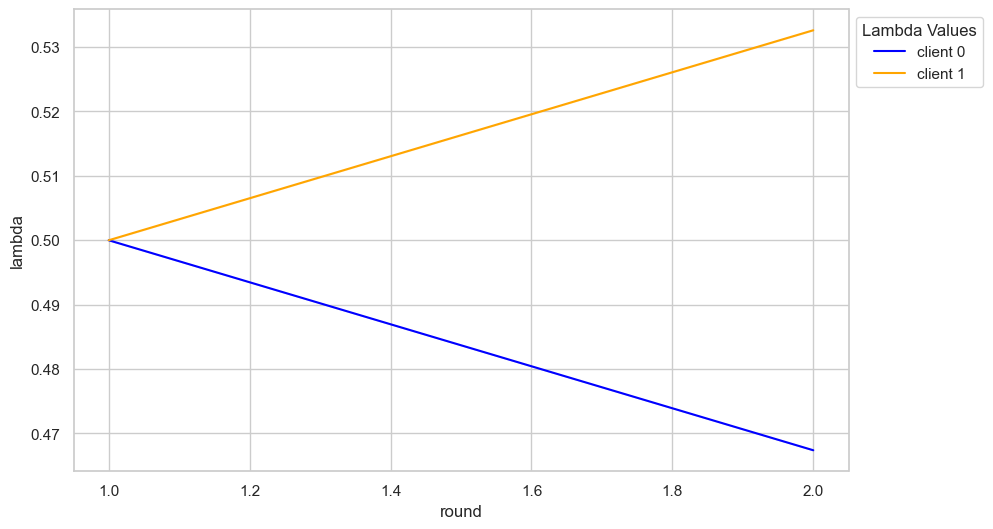

In [ ]:
##################################################
#  Plot lambda values 
###################################################


# from df summary print x the rounds and y the lambdas 
df_summary['round'] = df_summary['round'].astype(int)
df_summary = df_summary[df_summary['round'] > 0]  # filter out round 0
# explode lambdas 
# lambdas contains a vector 
# take out the 2 lambdas and put them in a new column called lambda and a new column called client and containig 0 or 1\
df_summary['lambda_0'] = df_summary['lambdas'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan)
df_summary['lambda_1'] = df_summary['lambdas'].apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else np.nan)
# ensure round is int
# plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_summary, x='round', y='lambda_0', label = "client 0", markers=True, dashes=False, color='blue', legend=True)
sns.lineplot(data=df_summary, x='round', y='lambda_1', label = "client 1", markers=True, dashes=False, color='orange', legend=True)
plt.xlabel('round')
plt.ylabel('lambda')
# add legend manually 
# make legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Lambda Values')
# add manual legend for lambda 
plt.show()

In [139]:
df

,round,loss,centralized_accuracy,lr,batch_size,clipping,lrdecay,localepochs,decay_onset,dataset_name,offset,alpha,aggregation,hyperparameters,type,federated_evaluate_accuracy
0,0,78960.872070,15.803067,0.001,64,False,1.0,2,15,ampfreq_noniid_offset_5.0,5.0,0.5,FedODE,"lr: 0.001, batch_size: 64, clipping: False, lr...",centralized,NaN
1,1,78911.894531,15.801944,0.001,64,False,1.0,2,15,ampfreq_noniid_offset_5.0,5.0,0.5,FedODE,"lr: 0.001, batch_size: 64, clipping: False, lr...",centralized,NaN
2,2,78928.054688,15.800062,0.001,64,False,1.0,2,15,ampfreq_noniid_offset_5.0,5.0,0.5,FedODE,"lr: 0.001, batch_size: 64, clipping: False, lr...",centralized,NaN
0,0,62571.675781,12.637894,0.001,64,False,1.0,1,15,ampfreq_noniid_mini_offset_5.0,5.0,0.5,FedODE,"lr: 0.001, batch_size: 64, clipping: False, lr...",centralized,NaN
1,1,61798.921875,12.431949,0.001,64,False,1.0,1,15,ampfreq_noniid_mini_offset_5.0,5.0,0.5,FedODE,"lr: 0.001, batch_size: 64, clipping: False, lr...",centralized,NaN
2,2,60787.429688,12.247850,0.001,64,False,1.0,1,15,ampfreq_noniid_mini_offset_5.0,5.0,0.5,FedODE,"lr: 0.001, batch_size: 64, clipping: False, lr...",centralized,NaN
0,1,79048.064453,NaN,0.001,64,False,1.0,2,15,ampfreq_noniid_offset_5.0,5.0,0.5,FedODE,"lr: 0.001, batch_size: 64, clipping: False, lr...",federated,15.823420
1,2,79088.836914,NaN,0.001,64,False,1.0,2,15,ampfreq_noniid_offset_5.0,5.0,0.5,FedODE,"lr: 0.001, batch_size: 64, clipping: False, lr...",federated,15.828018
0,1,61634.265625,NaN,0.001,64,False,1.0,1,15,ampfreq_noniid_mini_offset_5.0,5.0,0.5,FedODE,"lr: 0.001, batch_size: 64, clipping: False, lr...",federated,12.440928
1,2,60227.130859,NaN,0.001,64,False,1.0,1,15,ampfreq_noniid_mini_offset_5.0,5.0,0.5,FedODE,"lr: 0.001, batch_size: 64, clipping: False, lr...",federated,12.249458


In [138]:
# Filter only the rows relevant for loss comparison
loss_df = df[df['type'].isin(["centralized", "federated"])]
loss_df = loss_df[loss_df['round'] == loss_df['round'].max()]
# Keep centralized loss (federated is quite similar, we can double check later)

# Remove learning rate 0.01
lr = 0.001
bs = 64
local_epochs = 10
type = "centralized"  # or "federated", but we are only interested in centralized loss here

# alpha smaller than 0.5

loss_df = loss_df[loss_df['localepochs'] == local_epochs]
loss_df = loss_df[loss_df['type'] == type]
loss_df = loss_df[loss_df['lr'] == lr]
loss_df = loss_df[loss_df['batch_size'] == bs]

# fig size
plt.figure(figsize=(10, 8))
# Create FacetGrid
g = sns.FacetGrid(
    loss_df,
    col="alpha",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True
)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='offset',
    y='loss',
    hue='aggregation',
    style='type',
    palette='tab10',
    markers=True
)

# Adjustments
g.set_axis_labels("offset", "last loss")
#g.set_titles(" alpha {col_name}")
g.set(ylim=(0, None))


# Move legend outside
g.add_legend(title ="aggregation")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
g.fig.suptitle(f"batch Size {bs}, lr {lr}", fontsize=10, y=1.00)
plt.tight_layout()
plt.show()


ValueError: Number of columns must be a positive integer, not 0

<Figure size 1000x800 with 0 Axes>

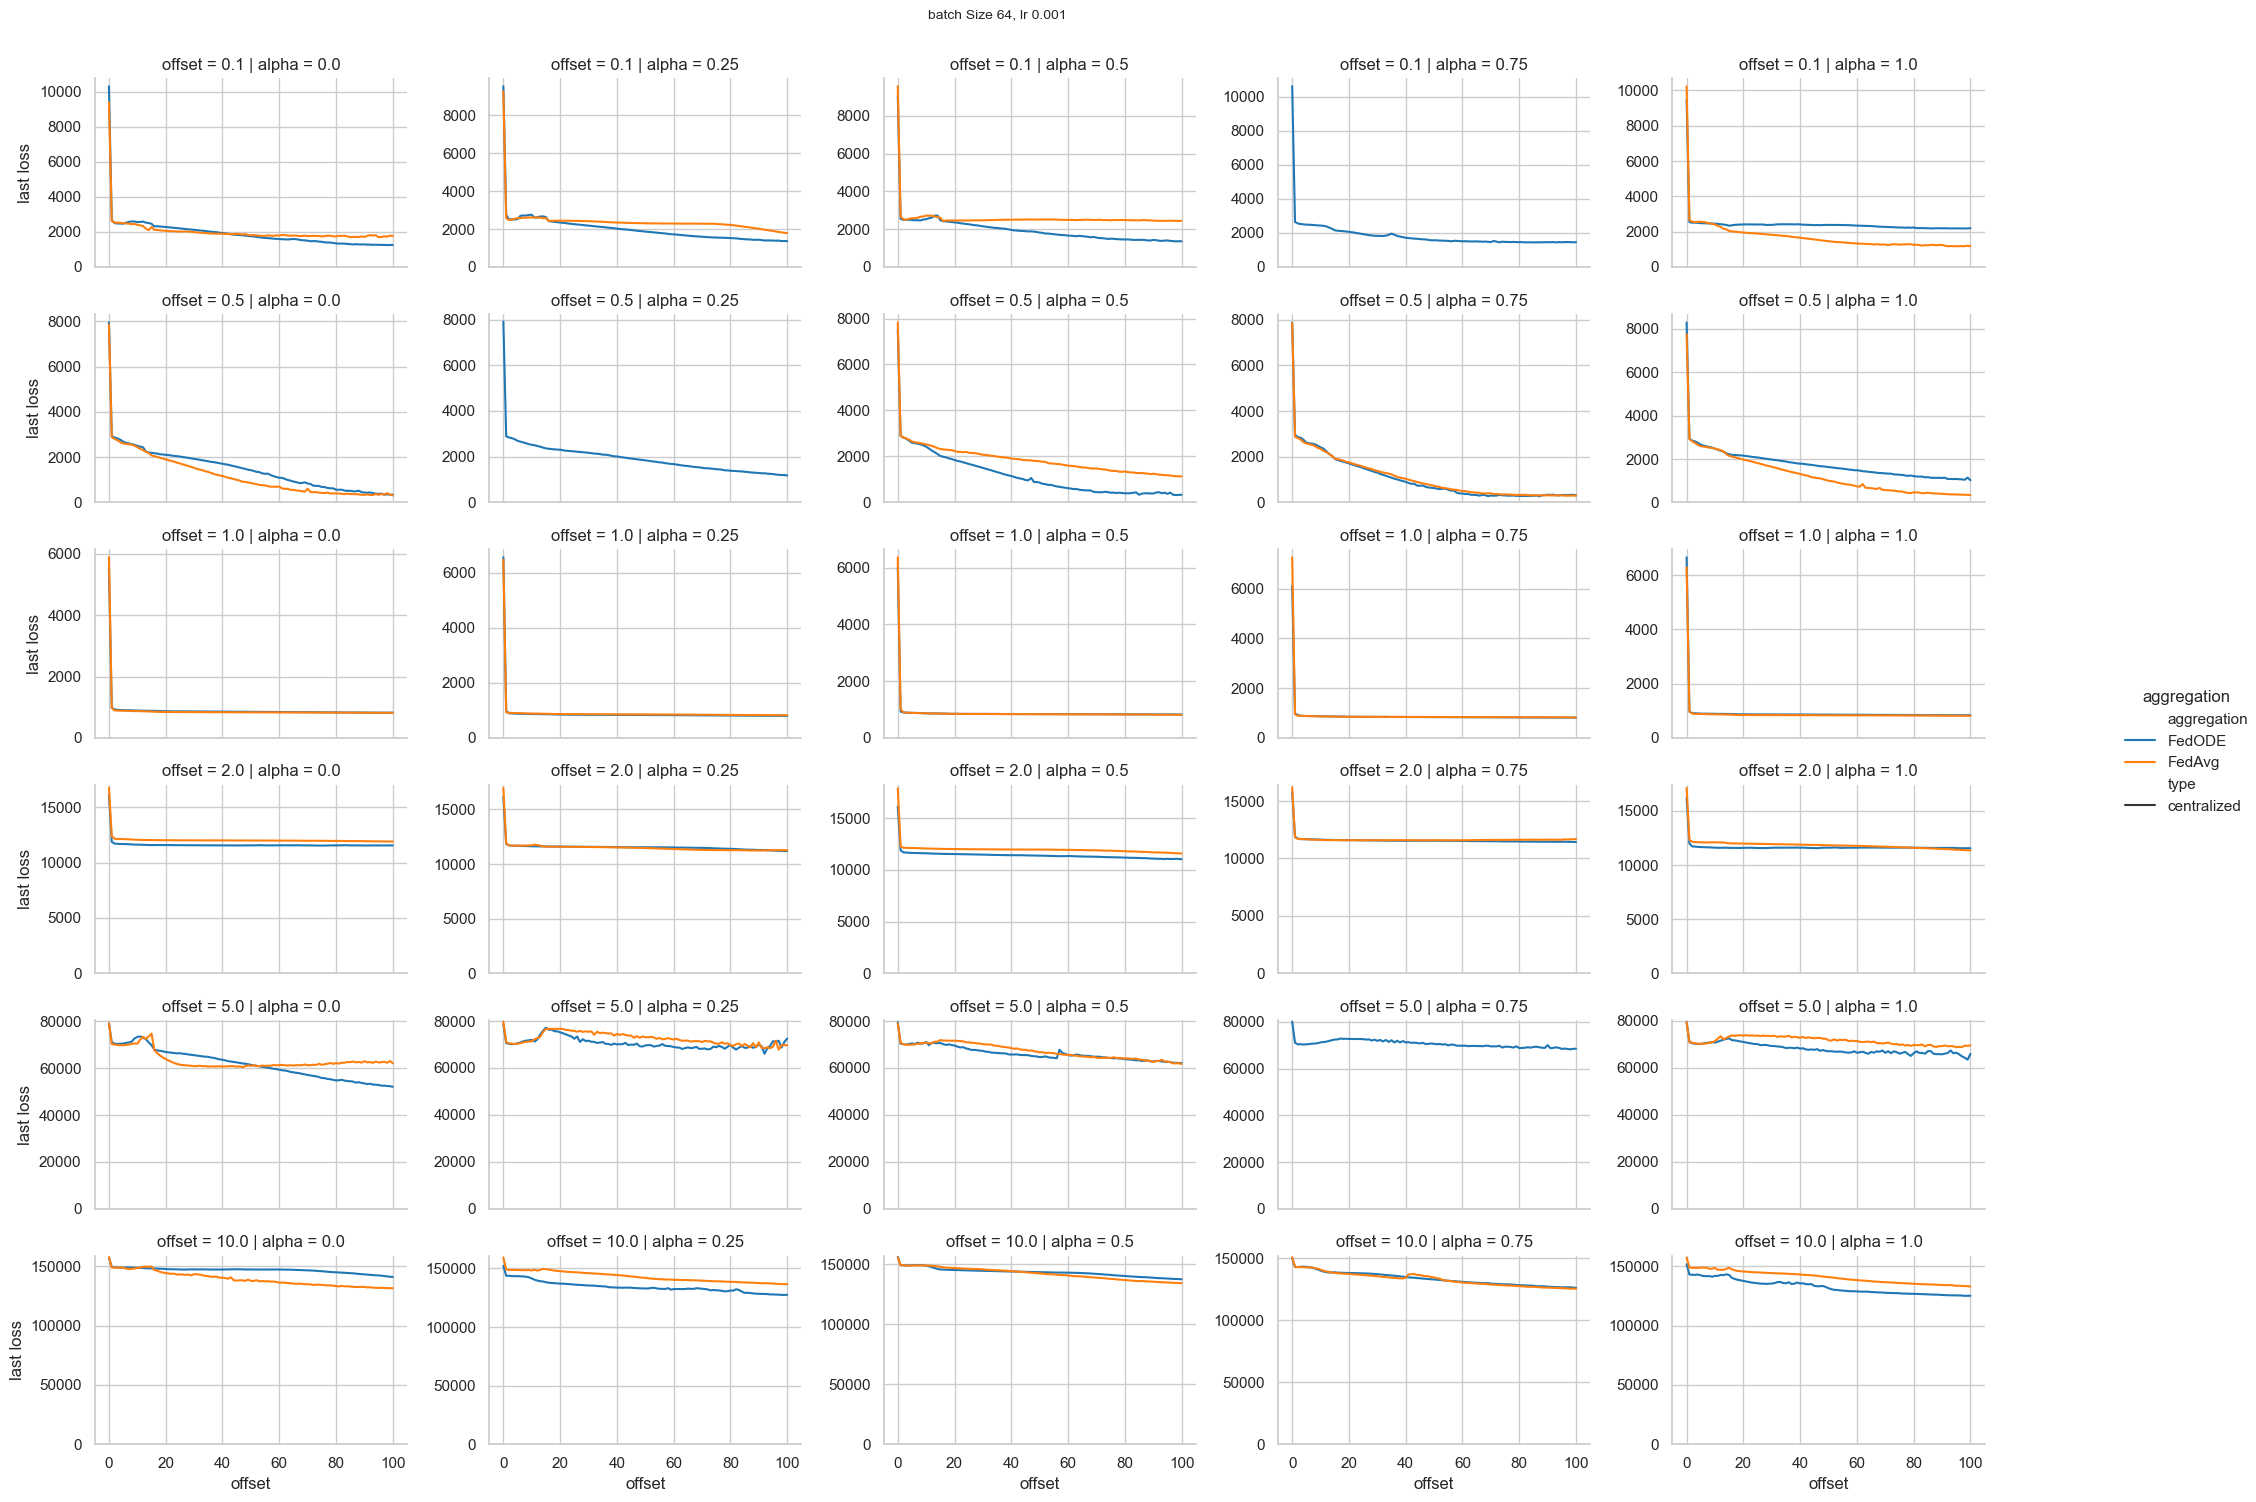

In [72]:
# Filter only the rows relevant for loss comparison
loss_df = df[df['type'].isin(["centralized", "federated"])]

# Keep centralized loss (federated is quite similar, we can double check later)

# Remove learning rate 0.01
lr = 0.001
bs = 64
local_epochs = 10
type = "centralized"

# alpha smaller than 0.5

loss_df = loss_df[loss_df['localepochs'] == local_epochs]
loss_df = loss_df[loss_df['type'] == type]
loss_df = loss_df[loss_df['lr'] == lr]
loss_df = loss_df[loss_df['batch_size'] == bs]

# fig size
plt.figure(figsize=(10, 8))
g = sns.FacetGrid(
    loss_df,
    col="alpha",
    row="offset",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=False

)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='round',
    y='loss',
    hue='aggregation',
    style='type',
    palette='tab10',
    markers=False
)

# Adjustments
g.set_axis_labels("offset", "last loss")
#g.set_titles(" alpha {col_name}")
g.set(ylim=(0, None))


# Move legend outside
g.add_legend(title ="aggregation")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
g.fig.suptitle(f"batch Size {bs}, lr {lr}", fontsize=10, y=1.00)
plt.tight_layout()
plt.show()


In [74]:
def plot_client_loss(file, type_loss ="train_loss", nrounds=None):

    # Load JSON file
    with open(file, "r") as f:
        data = json.load(f)


    # extarct from the file name the lr, batchsize, nlocalepochs, clipping, lrdecay
    # remove the last part of the file name
    file_path = file.replace("results_0.json", "")
    file_path = file_path.replace("results_1.json", "")
    meta_file = file_path + "meta.csv"
    print(f"Loading meta data from {meta_file}")
    meta_data = pd.read_csv(meta_file)
    lr = meta_data['lr'].item()
    batch_size = meta_data['batch_size'].item()
    clipping = meta_data['gradientclipping'].item()
    lrdecay = meta_data['lrdecay'].item()
    nlocalepochs = meta_data['localepochs'].item()
    decay_onset = meta_data['decay_onset'].item()
    title = f"lr: {lr}, batch_size: {batch_size}, nlocalepochs: {nlocalepochs}, decay_onset: {decay_onset}"

    # Extract loss values, rounds, and epochs
    loss_values = []
    rounds = []
    epochs = []

    epoch_count = 0  # To keep track of epochs

    for entry in data["client_train"]:
        round_number = entry["round"]
        for loss in entry[type_loss]:
            rounds.append(round_number)
            loss_values.append(loss)
            epochs.append(epoch_count)
            epoch_count += 1

    if nrounds is not None:
        # Filter the data to only include the first n rounds
        filtered_indices = [i for i, r in enumerate(rounds) if r < nrounds]
        loss_values = [loss_values[i] for i in filtered_indices]
        rounds = [rounds[i] for i in filtered_indices]
        epochs = [epochs[i] for i in filtered_indices]

    # make it smaller 
    plt.figure(figsize=(10, 2.5))
    # Plot loss values sequentially across rounds and epochs
    plt.plot(epochs, loss_values, marker='o', label="Loss across epochs", markersize=2)

    # add 1 to the round
    # Add verl lines for each round number
    for round_number in set(rounds):
        round_epochs = [i for i, r in enumerate(rounds) if r == round_number]
        if round_epochs:
            # Place a vertical line at the first epoch of each round
            # if it is not the first round
            if round_number != 0:
                plt.axvline(x=round_epochs[0], color='grey', linestyle='--', label=f"Round {round_number}", alpha=0.5, linewidth=1)

    # Customize x-axis ticks to represent rounds
    xticks = [i for i, round_number in enumerate(rounds) if i == 0 or rounds[i] != rounds[i-1]]
    # plot it only every 10th round
    xticks = [i for i in xticks if i % 100 == 0 or i == 0]
    plt.xticks(xticks, [rounds[i] for i in xticks])
    # log scale y 
    plt.title(title)
    plt.ylim(bottom=0)
    plt.xlabel("Round")
    plt.ylabel(f"Local {type_loss}")
    plt.tight_layout()
    plt.show()


In [ ]:

def read_client_file(file):
    # Read the meta.csv file
    meta_file = file.replace("results_0.json", "meta.csv")
    meta_file = meta_file.replace("results_1.json", "meta.csv")
    meta_data = pd.read_csv(meta_file)
    lr = meta_data['lr'].item()
    batch_size = meta_data['batch_size'].item()
    nlocalepochs = meta_data['localepochs'].item()
    
    # Read the results.json file
    with open(file, 'r') as f:
        data = json.load(f)
    
    # Plot centralized evaluate
    df = pd.DataFrame(data['client_train'])
    # Add the learning rate to the DataFrame
    df['lr'] = lr
    # Add the batch size to the DataFrame
    df['batch_size'] = batch_size
    # add nlocalepochs
    df['localepochs'] = nlocalepochs
    # add datasetname
    df['dataset_name'] = meta_data['dataset_name'].item()
    # extrat the last part of the dataset name
    df['offset'] = df['dataset_name'].apply(lambda x: x.split('_')[-1])
    # make it float
    df['offset'] = df['offset'].astype(float)
    # alpha
    df['alpha'] = meta_data['alpha'].item()

    # Aggregation column 
    # Check if file contins "FedAvg" in the path name
    if "FedAvg" in file:
        # if the path name contains "FedAvg" then add aggregation column "FedAvg"
        df['aggregation'] = "FedAvg"
    else:
        # if the path name does not contain "FedAvg" then add aggregation column "FedProx"
        df['aggregation'] = "FedODE"

    return df

clients_json = glob.glob(f"../results_ampfreq/**/federated_training/**/100_rounds/**/results_0.json", recursive=True)
len(clients_json)


57

In [126]:
# For all files, read the client_train data

df = pd.DataFrame()
for file in clients_json:
    df_0 = read_client_file(file)
    df_0["client"] = 0  # Add client column with value 0
    df_1 = read_client_file(file.replace("results_0.json", "results_1.json"))
    df_1["client"] = 1  # Add client column with value 1
    clients= pd.concat([df_0, df_1])
    df = pd.concat([df, clients])

df


,train_loss,train_mse,val_loss,val_mse,nodesolve,weights,grad_norms,lr,round,batch_size,localepochs,dataset_name,offset,alpha,aggregation,client
0,"[4621.626953125, 3689.85791015625, 3168.139892...","[0.92698073387146, 0.7426673769950867, 0.63956...","[4567.423095703125, 3654.067138671875, 2994.62...","[0.9168806970119476, 0.7350090891122818, 0.602...","[26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 2...",None,"[[encoder_z0.GRU_update.update_gate.0.weight, ...",0.001,0,64,10,ampfreq_noniid_offset_0.5,0.5,0.75,FedODE,0
1,"[2506.684814453125, 2487.79150390625, 2566.993...","[0.5027772784233093, 0.4986199736595154, 0.514...","[2722.2967529296875, 2499.9098510742188, 2541....","[0.5465939193964005, 0.5014200285077095, 0.509...","[26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 2...",None,"[[encoder_z0.GRU_update.update_gate.0.weight, ...",0.001,1,64,10,ampfreq_noniid_offset_0.5,0.5,0.75,FedODE,0
2,"[2441.855224609375, 2447.678466796875, 2495.75...","[0.48946234583854675, 0.49066293239593506, 0.5...","[2544.8934936523438, 2441.1888427734375, 2465....","[0.5103849768638611, 0.48955485969781876, 0.49...","[26, 26, 26, 26, 26, 26, 26, 32, 32, 32, 32, 3...",None,"[[encoder_z0.GRU_update.update_gate.0.weight, ...",0.001,2,64,10,ampfreq_noniid_offset_0.5,0.5,0.75,FedODE,0
3,"[2418.3759765625, 2412.860595703125, 2446.9985...","[0.4847424030303955, 0.4835304021835327, 0.490...","[2513.70458984375, 2413.1118774414062, 2421.40...","[0.5046081244945526, 0.4838418588042259, 0.485...","[38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 3...",None,"[[encoder_z0.GRU_update.update_gate.0.weight, ...",0.001,3,64,10,ampfreq_noniid_offset_0.5,0.5,0.75,FedODE,0
4,"[2331.081298828125, 2308.838623046875, 2333.69...","[0.4673479199409485, 0.46307915449142456, 0.46...","[2405.7291870117188, 2312.1322631835938, 2296....","[0.4824874550104141, 0.4636054188013077, 0.460...","[38, 50, 50, 38, 38, 38, 38, 38, 38, 38, 38, 3...",None,"[[encoder_z0.GRU_update.update_gate.0.weight, ...",0.001,4,64,10,ampfreq_noniid_offset_0.5,0.5,0.75,FedODE,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"[1637.6142578125, 1621.3701171875, 1544.241455...","[0.3286546766757965, 0.32561343908309937, 0.30...","[1627.0187072753906, 1597.2568054199219, 1537....","[0.3264646679162979, 0.32064731419086456, 0.30...","[80, 80, 80, 74, 68, 74, 68, 68, 68, 68, 68, 6...",None,"[[encoder_z0.GRU_update.update_gate.0.weight, ...",0.001,95,64,10,ampfreq_noniid_offset_0.1,0.1,0.50,FedAvg,1
96,"[1617.62939453125, 1628.77001953125, 1533.8348...","[0.3246716856956482, 0.32733482122421265, 0.30...","[1619.4859619140625, 1599.1898498535156, 1533....","[0.32521239668130875, 0.32137730717658997, 0.3...","[80, 80, 80, 68, 74, 74, 68, 68, 68, 68, 62, 6...",None,"[[encoder_z0.GRU_update.update_gate.0.weight, ...",0.001,96,64,10,ampfreq_noniid_offset_0.1,0.1,0.50,FedAvg,1
97,"[1615.682861328125, 1615.735107421875, 1526.77...","[0.32410016655921936, 0.32411935925483704, 0.3...","[1619.3908081054688, 1585.903076171875, 1525.5...","[0.3249164745211601, 0.31825917959213257, 0.30...","[80, 80, 80, 74, 74, 68, 62, 62, 62, 62, 62, 6...",None,"[[encoder_z0.GRU_update.update_gate.0.weight, ...",0.001,97,64,10,ampfreq_noniid_offset_0.1,0.1,0.50,FedAvg,1
98,"[1612.7818603515625, 1614.3695068359375, 1519....","[0.3236897885799408, 0.3238980174064636, 0.304...","[1610.50341796875, 1582.8583984375, 1518.82138...","[0.3232397213578224, 0.3179863393306732, 0.304...","[80, 80, 68, 74, 68, 68, 62, 62, 62, 62, 62, 6...",None,"[[encoder_z0.GRU_update.update_gate.0.weight, ...",0.001,98,64,10,ampfreq_noniid_offset_0.1,0.1,0.50,FedAvg,1


In [127]:
# check unique offset in df 
offsets = df['offset'].unique()
print(f"Unique offsets in the dataset: {offsets}")

Unique offsets in the dataset: [ 0.5  2.   1.  10.   5.   0.1]


In [128]:
# keep only columns nodesolve, offset, round,client
df = df[['nodesolve', 'offset', 'round', 'client', 'lr', 'batch_size', 'localepochs', 'aggregation', 'alpha']]
# explode the nodesolve column
df = df.explode('nodesolve')
# convert nodesolve to float
df['nodesolve'] = df['nodesolve'].astype(float)
df

,nodesolve,offset,round,client,lr,batch_size,localepochs,aggregation,alpha
0,26.0,0.5,0,0,0.001,64,10,FedODE,0.75
0,26.0,0.5,0,0,0.001,64,10,FedODE,0.75
0,26.0,0.5,0,0,0.001,64,10,FedODE,0.75
0,26.0,0.5,0,0,0.001,64,10,FedODE,0.75
0,26.0,0.5,0,0,0.001,64,10,FedODE,0.75
...,...,...,...,...,...,...,...,...,...
99,68.0,0.1,99,1,0.001,64,10,FedAvg,0.50
99,62.0,0.1,99,1,0.001,64,10,FedAvg,0.50
99,62.0,0.1,99,1,0.001,64,10,FedAvg,0.50
99,62.0,0.1,99,1,0.001,64,10,FedAvg,0.50


<Figure size 1000x1300 with 0 Axes>

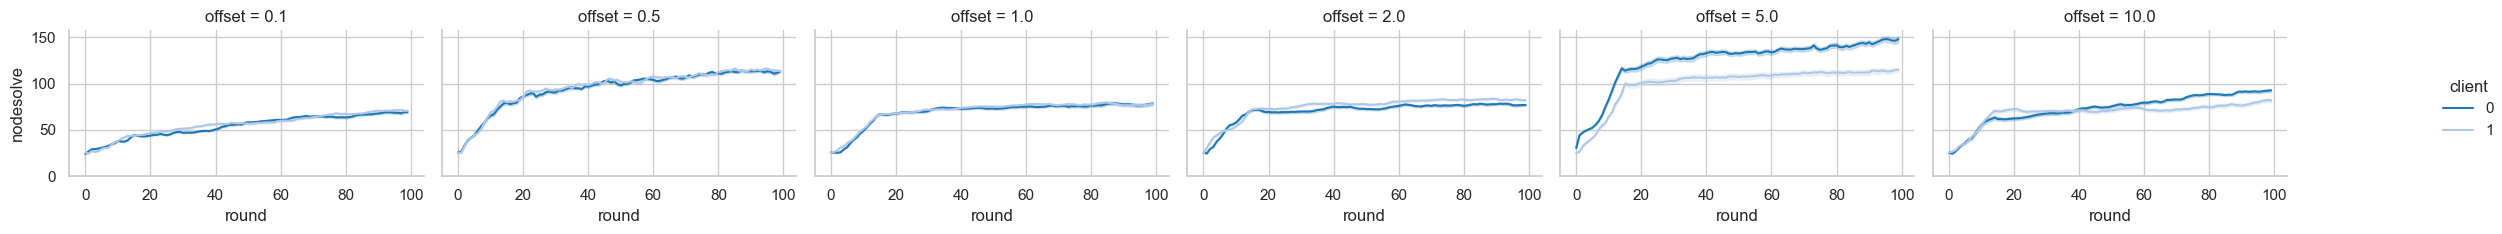

In [134]:
# Filter only the rows relevant for loss comparison
loss_df = df
# Keep centralized loss (federated is quite similar, we can double check later)

# fig size
plt.figure(figsize=(10, 13))
# Create FacetGrid
g = sns.FacetGrid(
    loss_df,
    col="offset",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True
)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='round',
    y='nodesolve',
    hue='client',
    palette='tab20',
    markers=True
)

# Adjustments
#g.set_titles(" alpha {col_name}")
g.set(ylim=(0, None))


g.add_legend(title ="client")
g._legend.set_bbox_to_anchor((1.05, 0.5))
g._legend.set_loc("center left")

plt.tight_layout()
plt.show()

In [112]:
plt.figure(figsize=(10, 8))
sns.lineplot(
    data=df,
    x='offset',
    y='nodesolve',
    hue='client',
    style='aggregation',
    markers=True,
    dashes=False,
    palette='tab10'
)
plt.title("Number of ODE solves per client across offsets")
plt.xlabel("Offset")
plt.ylabel("Number of ODE solves")
plt.ylim(0, None)
plt.legend(title='Client and Aggregation', loc='upper left')
plt.tight_layout()
plt.show()

TypeError: unhashable type: 'list'

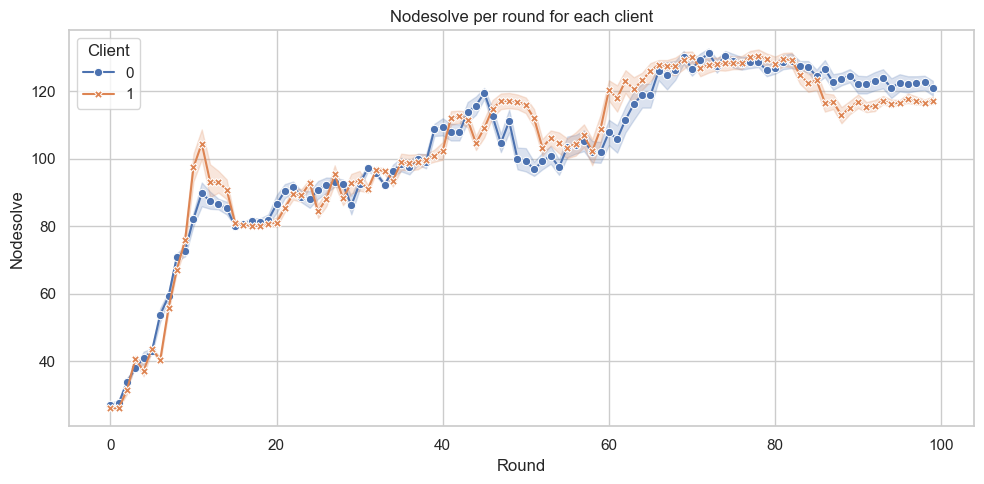

In [96]:
# plot the nodesolve for the two clients
plt.figure(figsize=(10, 5))
sns.lineplot(data=nodesolves_df, x='round', y='nodesolve', hue='client', style='client', markers=True, dashes=False)
plt.title("Nodesolve per round for each client")
plt.xlabel("Round")
plt.ylabel("Nodesolve")
plt.legend(title='Client')
plt.tight_layout()
plt.show()